# Water Extent <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[ls8_usgs_sr_scene](https://explorer.digitalearth.africa/ls8_usgs_sr_scene), 
[ga_ls8c_wofs_2_annual_summary](ga_ls8c_wofs_2_annual_summary),



## Background
An *optional* overview of the scientific, economic or environmental management issue or challenge being addressed by Digital Earth Africa. 
For `Beginners_Guide` or `Frequently_Used_Code` notebooks, this may include information about why the particular technique or approach is useful or required. 
If you need to cite a scientific paper or link to a website, use a persistent DOI link if possible and link in-text (e.g. [Dhu et al. 2017](https://doi.org/10.1080/20964471.2017.1402490)).

## Description
A _compulsory_ description of the notebook, including a brief overview of how Digital Earth Africa helps to address the problem set out above.
It can be good to include a run-down of the tools/methods that will be demonstrated in the notebook:

1. First we do this
2. Then we do this
3. Finally we do this

***

## Getting started

Provide any particular instructions that the user might need, e.g. To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

Use standard import commands; some are shown below. 
Begin with any `iPython` magic commands, followed by standard Python packages, then any additional functionality you need from the `Scripts` directory.

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import xarray as xr

sys.path.append('../Scripts')
from deafrica_datahandling import mostcommon_crs, load_ard, wofs_fuser
from deafrica_bandindices import calculate_indices
from deafrica_plotting import display_map, rgb
from deafrica_dask import create_local_dask_cluster



### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app='water_extent')

create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:41791 Dashboard: /user/ahicks/proxy/8787/status,Cluster Workers: 1 Cores: 2 Memory: 14.18 GB


In [3]:
# Define the area of interest

# Lake Sulunga, Tanzania
# lat_range = (-6.3605, -5.8252) # Large 
# lon_range  = (34.9756, 35.4535) # Large
lat_range = (-6.2593, -5.8701) # Small (close fit)
lon_range = (34.9901, 35.3641) #  Small (close fit)


# Set the range of dates for the complete sample
time = ('2013-01-01', '2019-12-01')


In [4]:
display_map(x=lon_range, y=lat_range, zoom_bias=1 )

## Load and view Landsat data

The first step in the analysis is to load Landsat data for the specified area of interest and time range. 

The code below will create a query dictionary for our region of interest, find the correct `crs` object for the area of interest, and then load the Landsat data using the `load_ard` function.
For more infmation, see the [Using load_ard notebook](../Frequently_used_code/Using_load_ard.ipynb).
The function will also automatically mask out clouds from the dataset, allowing us to focus on pixels that contain useful data.
It will also exclude images where more than 70% of the pixels are masked, which is set using the `min_gooddata` parameter in the `load_ard` call.


In [5]:
#Create a query object

start_year = 2013
end_year = 2019

query = {
    'x': lon_range,
    'y': lat_range,
    'group_by': 'solar_day',
    'resolution': (-30, 30),
    'align': (15, 15),
    'time': (start_year, end_year)
}

# find the right crs for the location
crs = mostcommon_crs(dc=dc, product='ga_ls8c_wofs_2', query=query)


ds = dc.load(product=["ga_ls8c_wofs_2"],
             output_crs=crs,
             dask_chunks={'time': 1, 'x': 500, 'y': 500},
             fuse_func=wofs_fuser,
             **query
            )



../Scripts/deafrica_datahandling.py:600: UserWarning: Multiple UTM zones ['epsg:32637', 'epsg:32636'] were returned for this query. Defaulting to the most common zone: epsg:32636
  UserWarning)


In [6]:
ds

,Array,Chunk
Bytes,554.01 MB,250.00 kB
Shape,"(277, 1442, 1387)","(1, 500, 500)"
Count,2911 Tasks,2493 Chunks
Type,uint8,numpy.ndarray


In [33]:
pixel_length = query["resolution"][1]  # in metres
m_per_km = 1000  # conversion from metres to kilometres
area_per_pixel = pixel_length**2 / m_per_km**2

In [34]:
def calculate(x):
    return (x.count(dim=['x','y']) * area_per_pixel).values.sum()

In [42]:
ds_water = ds.where(ds.water.isin([0, 128]))

valid_threshold = ds_water.x.size * ds_water.y.size * 0.75  # Needs 75% to be water or land

water_observed = {}
i = 0
for time_range in ds_water.water.time.values:
    print(" Feature {:02}/{:02}\r".format(i + 1, len(ds_water.water.time.values)),
                  end='')
    con_time_range = pd.to_datetime(str(time_range)) 
    con_time_range = con_time_range.strftime('%Y-%m-%d')
    
    water = ds_water.water.sel(time=time_range)
    num_water_pixels = (water == 128).sum()
    num_valid_pixels = water.sum()
    
    if num_valid_pixels > valid_threshold:
        water_range = num_water_pixels * area_per_pixel

        if water_range > 100:
            water_observed[con_time_range] = water_range
        
    i += 1
# = ds_water.apply(calculate, axis=1)

# ds_water
# ds.water.time.year

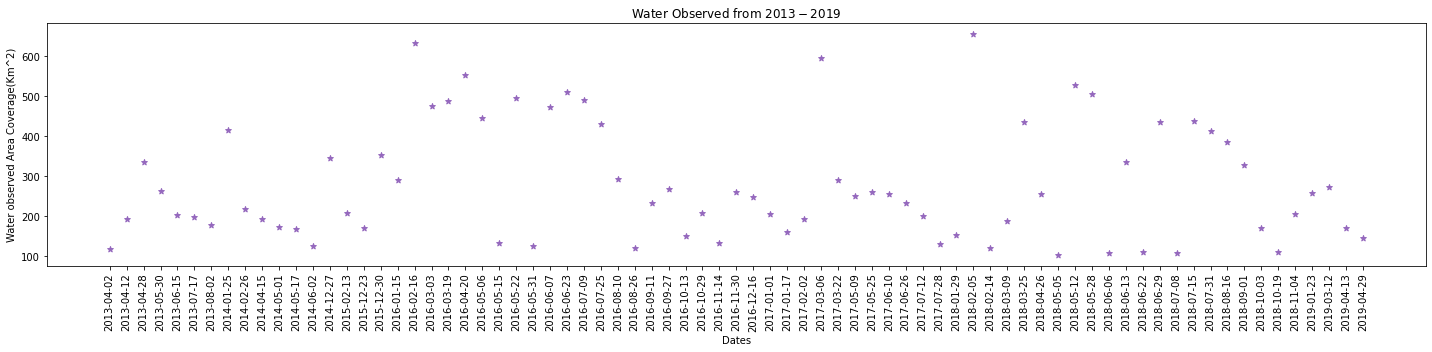

In [43]:
plt.figure(figsize=(20, 5))
plt.scatter(water_observed.keys(), water_observed.values(), marker='*', c='#9467bd')
plt.xticks(rotation=90)
plt.xlabel('Dates')
plt.ylabel('Water observed Area Coverage(Km^2)')
plt.title(f'Water Observed from ${start_year} - ${end_year}')
plt.tight_layout()  

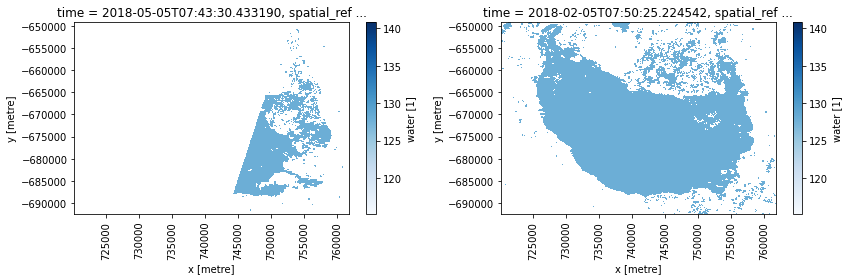

In [11]:
fig = plt.figure(figsize=(12, 4))
fig.add_subplot(1,2,1)
ds_water.water.sel(time=min(water_observed, key=water_observed.get)).plot(cmap='Blues')
plt.xticks(rotation=90)
fig.add_subplot(1,2,2)
ds_water.water.sel(time=max(water_observed, key=water_observed.get)).plot(cmap='Blues')
plt.xticks(rotation=90)
plt.tight_layout()

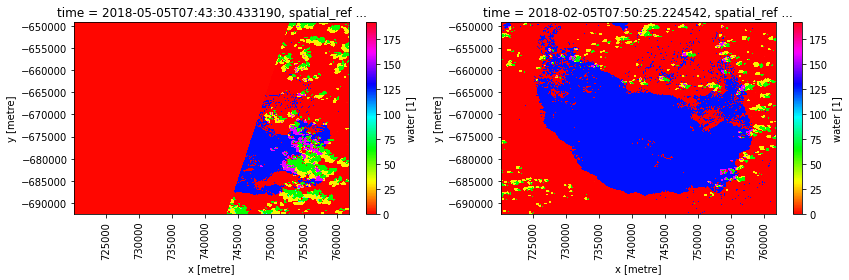

In [12]:
fig = plt.figure(figsize=(12, 4))
fig.add_subplot(1,2,1)
ds.water.sel(time=min(water_observed, key=water_observed.get)).plot(cmap='hsv')
plt.xticks(rotation=90)
fig.add_subplot(1,2,2)
ds.water.sel(time=max(water_observed, key=water_observed.get)).plot(cmap='hsv')
plt.xticks(rotation=90)
plt.tight_layout()

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** January 2020

**Compatible datacube version:** 

In [13]:
print(datacube.__version__)

1.8.0


## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index](https://) (placeholder as this does not exist yet)